In [1]:
!pip install xgboost
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import gc
import sys
import time
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from IPython.display import clear_output
from xgboost import XGBClassifier, DMatrix
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

pd.set_option('display.max_columns', None)

In [3]:
train_file = './train.gz'
test_file = './test.gz'
samplesubmision_file = './sampleSubmission.gz'

# EDA

In [4]:
chunksize = 10 ** 6
train_sample_frac = .05

total_train_count = 0
num_of_chunk = 0

train_df = pd.DataFrame()

drop_columns = ['id']
types_map = {}

In [6]:
top_100 = pd.read_csv(train_file, compression='gzip', nrows=100)
top_100.drop('id', inplace=True, axis=1)
top_100.head(3)

click      hour    C1  banner_pos   site_id site_domain site_category  \
0      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   
1      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   
2      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   

     app_id app_domain app_category device_id device_ip device_model  \
0  ecad2386   7801e8d9     07d7df22  a99f214a  ddd2926e     44956a24   
1  ecad2386   7801e8d9     07d7df22  a99f214a  96809ac8     711ee120   
2  ecad2386   7801e8d9     07d7df22  a99f214a  b3cf8def     8a4875bd   

   device_type  device_conn_type    C14  C15  C16   C17  C18  C19     C20  C21  
0            1                 2  15706  320   50  1722    0   35      -1   79  
1            1                 0  15704  320   50  1722    0   35  100084   79  
2            1                 0  15704  320   50  1722    0   35  100084   79

In [7]:
top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             100 non-null    int64 
 1   hour              100 non-null    int64 
 2   C1                100 non-null    int64 
 3   banner_pos        100 non-null    int64 
 4   site_id           100 non-null    object
 5   site_domain       100 non-null    object
 6   site_category     100 non-null    object
 7   app_id            100 non-null    object
 8   app_domain        100 non-null    object
 9   app_category      100 non-null    object
 10  device_id         100 non-null    object
 11  device_ip         100 non-null    object
 12  device_model      100 non-null    object
 13  device_type       100 non-null    int64 
 14  device_conn_type  100 non-null    int64 
 15  C14               100 non-null    int64 
 16  C15               100 non-null    int64 
 17  C16              

In [8]:
del top_100

## 取 5% 資料出來探索

In [5]:
types_map = {
    'id': np.dtype(str),
    'click': np.dtype('uint8'),
    'hour': np.dtype(int),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
}

In [12]:
num_of_chunk = 0
for chunk in pd.read_csv(train_file, compression='gzip', dtype=types_map, chunksize=chunksize):
    num_of_chunk += 1
    total_train_count += len(chunk)
    if num_of_chunk == 1:
        train_df = chunk.sample(frac=train_sample_frac, replace=False, random_state=2022)
    else:
        train_df = pd.concat([train_df, chunk.sample(frac=train_sample_frac, replace=False, random_state=123)], axis=0)
    print(f'Processing Chunk No.{ num_of_chunk }')

del chunk
clear_output()

print(f'num_of_chunk: {num_of_chunk}')
print(f'total_train_count: {total_train_count}')
print(f'train_df count: {len(train_df)}')

num_of_chunk: 41
total_train_count: 40428967
train_df count: 2021448


### 合併 train & test data

In [13]:
concat_df = pd.concat([train_df, pd.read_csv(test_file, compression='gzip', dtype=types_map)]).drop(['id'], axis=1)

### 時間處理

In [14]:
concat_df['weekday'] = pd.to_datetime(concat_df['hour'].astype(np.dtype(str)).apply(lambda x: f'20{x[:2]}-{x[2:4]}-{x[4:6]}')).dt.dayofweek.astype(str)

In [15]:
concat_df['hour'] = concat_df['hour'].apply(lambda x: x%100).astype(str)

### 各欄位的唯一值數量

In [16]:
for column in concat_df.columns:
    print(f'{column}: {len(concat_df[column].unique())}')

click: 3
hour: 24
C1: 7
banner_pos: 7
site_id: 3492
site_domain: 4328
site_category: 24
app_id: 5482
app_domain: 319
app_category: 31
device_id: 552801
device_ip: 1875291
device_model: 6320
device_type: 5
device_conn_type: 4
C14: 2660
C15: 8
C16: 9
C17: 470
C18: 4
C19: 68
C20: 169
C21: 62
weekday: 7


### 大量特徵處理

In [6]:
ctr_step = 0.1
large_features_columns = ['site_id', 'site_domain',
                          'app_id', 'app_domain',
                          'device_id', 'device_ip', 'device_model',
                          'C14', 'C17', 'C19', 'C20', 'C21']

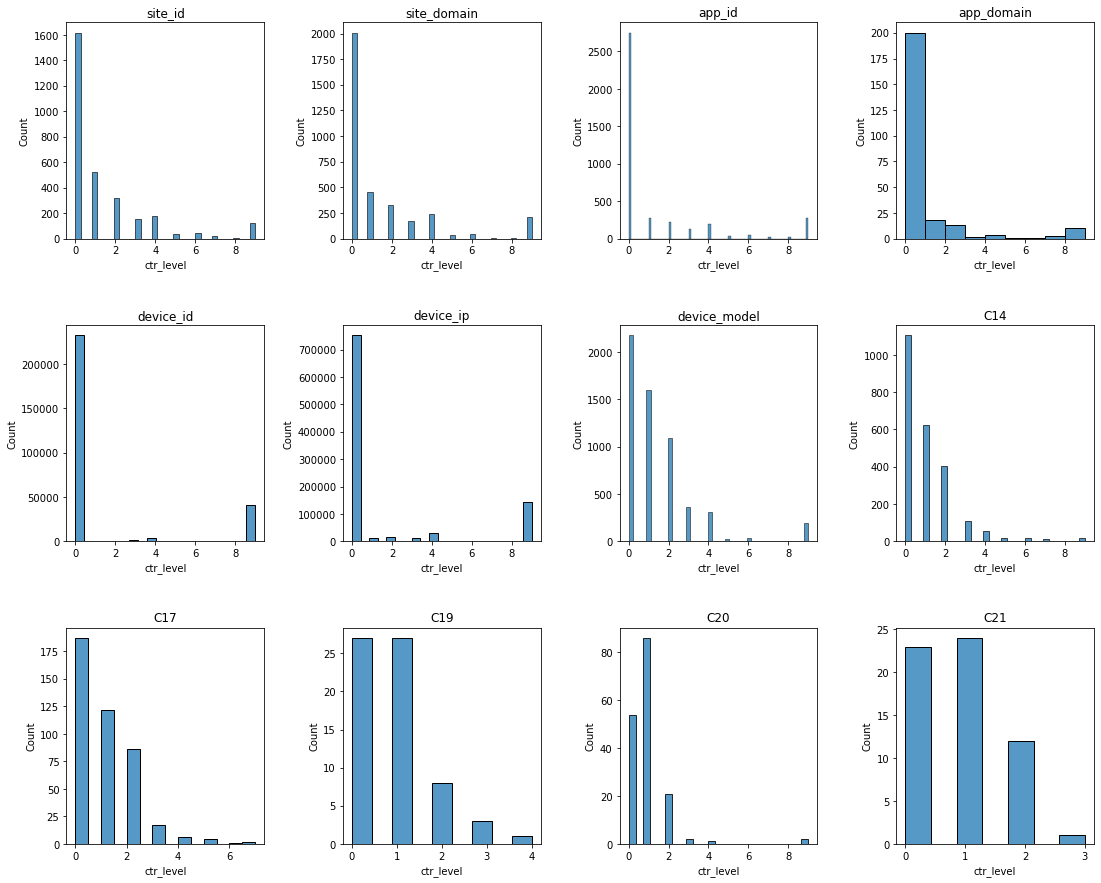

In [18]:
large_features_columns_mapping_dfs = {}

fig, ax = plt.subplots(3, 4, figsize=(15,12))
fig.tight_layout()

for i, column in enumerate(large_features_columns):
    print(column)
    df_0 = train_df[train_df['click'] == 0][column].value_counts()
    df_1 = train_df[train_df['click'] == 1][column].value_counts()
    df = pd.merge(left=df_0, right=df_1, how='outer', left_index=True, right_index=True, suffixes=('_0', '_1'))
    df.fillna(1e-6, inplace=True)
    df['ctr'] = df[f'{column}_1'] / (df[f'{column}_1'] + df[f'{column}_0'])
    df['ctr_level'] = (df['ctr'] // ctr_step).astype('uint8')
    
    large_features_columns_mapping_dfs[f'{column}'] = df['ctr_level'].copy()
    train_df[f'{column}_level'] = train_df[f'{column}'].apply(lambda x: large_features_columns_mapping_dfs[f'{column}'][str(x)])
    
    ax[i//4, i%4].set_title(f'{column}')
    sns.histplot(df, x='ctr_level', ax=ax[i//4, i%4])

del df_0, df_1, df
clear_output()
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

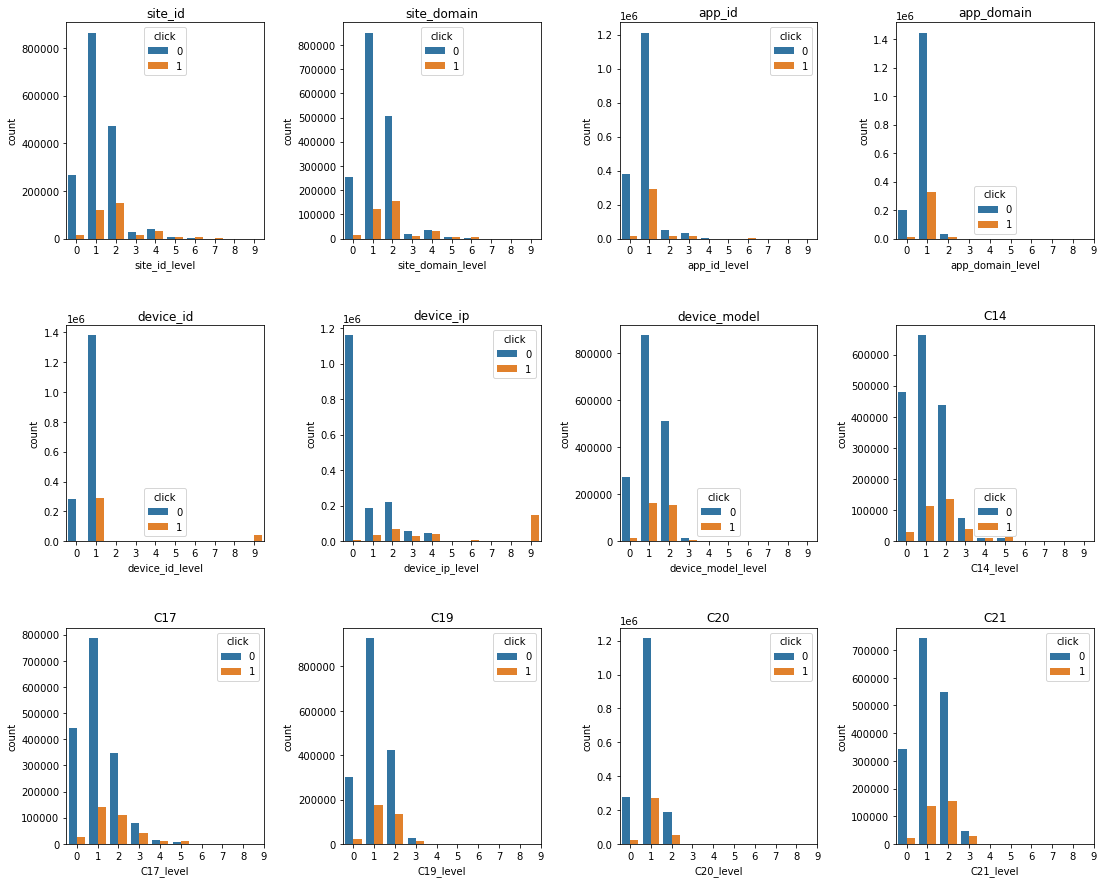

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
fig.tight_layout()

for i, column in enumerate(large_features_columns):
    sns.countplot(data=train_df, x=f'{column}_level', hue='click', ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'{column}')
    ax[i//4, i%4].set_xticks(list(range(10)))
    ax[i//4, i%4].set_xticklabels(list(range(10)))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [56]:
del train_df, concat_df

# 大量特徵資料轉換

## 特徵值對應表

In [7]:
large_features_columns_mapping_dfs = {}

for column in large_features_columns:
    print(column)
    
    df = pd.read_csv(train_file, compression='gzip', dtype=types_map, usecols=['click', column])
#     df, _ = train_test_split(df, test_size=0.20, random_state=2022)
#     df, _ = train_test_split(df, test_size=0.25, random_state=2022)
    
    df = df.groupby(column)['click'].agg(['count', 'sum']).reset_index()
    df['count'] = df['count'].apply(lambda x: 1e-6 if x == 0 else x)
    df['ctr_level'] = ((df['sum'] / df['count']) // ctr_step).astype(np.dtype('uint8'))
    df.drop(['count', 'sum'], inplace=True, axis=1)

    large_features_columns_mapping_dfs[column] = df.copy()
    del df
    clear_output()

for column in large_features_columns:
    print(f'{column}: {len(large_features_columns_mapping_dfs[column])}')

site_id: 4737
site_domain: 7745
app_id: 8552
app_domain: 559
device_id: 2686408
device_ip: 6729486
device_model: 8251
C14: 2626
C17: 435
C19: 68
C20: 172
C21: 60


## 特徵值轉換

In [8]:
columns = pd.read_csv(train_file, compression='gzip', nrows=1).columns.to_list()
columns = columns[1:]

In [9]:
concat_df = pd.concat([
    pd.read_csv(train_file, compression='gzip', dtype=types_map, usecols=[c for c in columns if c not in large_features_columns]),
    pd.read_csv(test_file, compression='gzip', dtype=types_map, usecols=[c for c in columns if c not in large_features_columns + ['click']]),
])

In [11]:
concat_df['weekday'] = pd.to_datetime(concat_df['hour'].astype(np.dtype(str)).apply(lambda x: f'20{x[:2]}-{x[2:4]}-{x[4:6]}')).dt.dayofweek.astype(str)
concat_df['hour'] = concat_df['hour'].apply(lambda x: x%100).astype(np.dtype('uint8'))

In [12]:
for column in large_features_columns:
    print(column)
    df = pd.concat([
        pd.read_csv(train_file, compression='gzip', dtype=types_map, usecols=[column]),
        pd.read_csv(test_file, compression='gzip', dtype=types_map, usecols=[column]),
    ])
    df[column] = pd.merge(left=df, right=large_features_columns_mapping_dfs[column], how='left', on=column)[['ctr_level']] \
                   .fillna(0) \
                   .rename({'ctr_level': column}) \
                   .astype(np.dtype('uint8'))
    concat_df = pd.concat([concat_df, df], axis=1)
    del df
    clear_output()

In [13]:
concat_df = pd.get_dummies(concat_df)

In [14]:
concat_df[concat_df['click'].notna()].to_csv('train.csv', index=False)
concat_df[concat_df['click'].isna()].drop('click', axis=1).to_csv('test.csv', index=False)

In [15]:
del concat_df

# Training model

In [5]:
train_df = pd.read_csv('train.csv', dtype=np.dtype('uint8'))

In [17]:
balanced_train_df = train_df[train_df['click'] == 0].sample(n=len(train_df[train_df['click'] == 1]), random_state=2022)
balanced_train_df = pd.concat([balanced_train_df, train_df[train_df['click'] == 1]]).sample(frac=1)
len(balanced_train_df)

13730132

In [18]:
del train_df

In [19]:
train_df, test_df = train_test_split(balanced_train_df, test_size=0.20, random_state=2022)
train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=2022)

In [20]:
train_df.to_csv('train_n.csv', index=False)
valid_df.to_csv('valid_n.csv', index=False)
test_df.to_csv('test_n.csv', index=False)

In [21]:
del balanced_train_df

In [6]:
train_df = pd.read_csv('train_n.csv', dtype=np.dtype('uint8'))
valid_df = pd.read_csv('valid_n.csv', dtype=np.dtype('uint8'))
test_df = pd.read_csv('test_n.csv', dtype=np.dtype('uint8'))

In [7]:
print(f'train: {len(train_df)}, valid: {len(valid_df)}, test: {len(test_df)}')

train: 8238078, valid: 2746027, test: 2746027


In [8]:
y_train = train_df['click']
X_train = train_df.drop('click', axis=1)
y_valid = valid_df['click']
X_valid = valid_df.drop('click', axis=1)
y_test = test_df['click']
X_test = test_df.drop('click', axis=1)

In [9]:
del train_df, valid_df, test_df

## Train model

In [10]:
estimator = XGBClassifier(tree_method='gpu_hist',
                          n_estimators=50,
                          nthread=-1,
                          objective='binary:logistic')

estimator.fit(X_train, y_train)
predict = estimator.predict(X_valid)
score = roc_auc_score(y_valid, predict)
score

0.7922774691680415

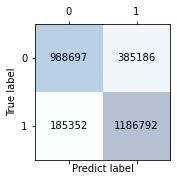

In [11]:
predict = estimator.predict(X_valid)
confmat = confusion_matrix(y_true=y_valid, y_pred=predict, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

## Important columns

In [12]:
df = pd.DataFrame({
    'column': X_train.columns,
    'important': estimator.feature_importances_
})
df = df[df['important'] > 0.0025].sort_values('important', ascending=False)
print(f'欄位數： {len(df["column"].to_list())}')
print(df["column"].to_list())

欄位數： 36
['device_ip', 'device_id', 'site_id', 'site_domain', 'C14', 'site_category_28905ebd', 'app_category_0f2161f8', 'C17', 'app_id', 'site_category_f028772b', 'app_category_dc97ec06', 'site_category_76b2941d', 'C16_480', 'site_category_50e219e0', 'C20', 'app_category_8ded1f7a', 'C21', 'banner_pos_0', 'C15_300', 'C16_250', 'site_category_f66779e6', 'device_conn_type_2', 'C15_216', 'app_category_07d7df22', 'device_model', 'app_category_cef3e649', 'site_category_dedf689d', 'C18_1', 'banner_pos_1', 'C18_3', 'C19', 'app_category_f95efa07', 'device_conn_type_0', 'hour', 'C15_320', 'C1_1012']


In [13]:
important_columns = ['device_ip', 'device_id', 'site_id', 'site_domain', 'C14', 'site_category_28905ebd', 'app_category_0f2161f8', 'C17', 'app_id', 'site_category_f028772b', 'app_category_dc97ec06', 'site_category_76b2941d', 'C16_480', 'site_category_50e219e0', 'C20', 'app_category_8ded1f7a', 'C21', 'banner_pos_0', 'C15_300', 'C16_250', 'site_category_f66779e6', 'device_conn_type_2', 'C15_216', 'app_category_07d7df22', 'device_model', 'app_category_cef3e649', 'site_category_dedf689d', 'C18_1', 'banner_pos_1', 'C18_3', 'C19', 'app_category_f95efa07', 'device_conn_type_0', 'hour', 'C15_320', 'C1_1012']

In [14]:
X_train = X_train[important_columns]
X_valid = X_valid[important_columns]
X_test = X_test[important_columns]

## Subsmaple value (Overfitting)

In [18]:
subsmaple_range = [x/100 for x in range(10,101,10)]
scores = []

for subsample in subsmaple_range:
    print(subsample)
    estimator = XGBClassifier(tree_method='gpu_hist',
                              subsample=subsample,
                              min_child_weight=10,
                              max_depth=10,
                              n_estimators=50,
                              nthread=-1,
                              objective='binary:logistic')
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_valid)
    score = roc_auc_score(y_valid, predict)
    scores.append(score)
    clear_output()

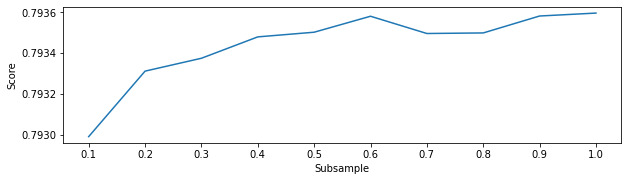

In [19]:
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.lineplot(x=subsmaple_range, y=scores)
plt.xticks(subsmaple_range)
plt.xlabel('Subsample')
plt.ylabel('Score')
plt.show()

In [20]:
subsample = 0.6

## Min child weight value (Overfitting)

In [22]:
min_child_weight_range = list(range(5,100,5))
scores = []

for min_child_weight in min_child_weight_range:
    print(min_child_weight)
    estimator = XGBClassifier(tree_method='gpu_hist',
                              subsample=subsample,
                              min_child_weight=min_child_weight,
                              max_depth=10,
                              n_estimators=50,
                              nthread=-1,
                              objective='binary:logistic')
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_valid)
    score = roc_auc_score(y_valid, predict)
    scores.append(score)
    clear_output()

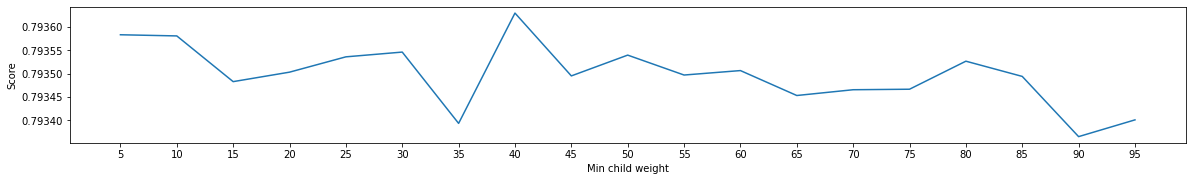

In [23]:
fig, ax = plt.subplots(figsize=(20, 2.5))
sns.lineplot(x=min_child_weight_range, y=scores)
plt.xticks(min_child_weight_range)
plt.xlabel('Min child weight')
plt.ylabel('Score')
plt.show()

In [24]:
min_child_weight = 10

## Max depth value (Overfitting)

In [95]:
max_depth_range = list(range(2,15))
scores = []

for max_depth in max_depth_range:
    print(max_depth)
    estimator = XGBClassifier(tree_method='gpu_hist',
                              subsample=subsample,
                              min_child_weight=min_child_weight,
                              max_depth=max_depth,
                              n_estimators=50,
                              nthread=-1,
                              objective='binary:logistic')
    estimator.fit(X_train, y_train)
    predict = estimator.predict_proba(X_valid)
    score = log_loss(y_valid, predict)
    scores.append(score)
    clear_output()

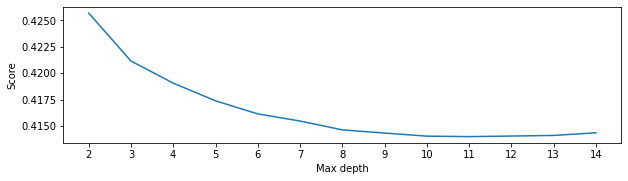

In [96]:
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.lineplot(x=max_depth_range, y=scores)
plt.xticks(max_depth_range)
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.show()

In [97]:
max_depth = 10

## N estimators value (Overfitting)

In [98]:
n_estimators_range = list(range(10,120,10))
scores = []

for n_estimators in n_estimators_range:
    print(n_estimators)
    estimator = XGBClassifier(tree_method='gpu_hist',
                              subsample=subsample,
                              min_child_weight=min_child_weight,
                              max_depth=max_depth,
                              n_estimators=n_estimators,
                              nthread=-1,
                              objective='binary:logistic')
    estimator.fit(X_train, y_train)
    predict = estimator.predict_proba(X_valid)
    score = log_loss(y_valid, predict)
    scores.append(score)
    clear_output()

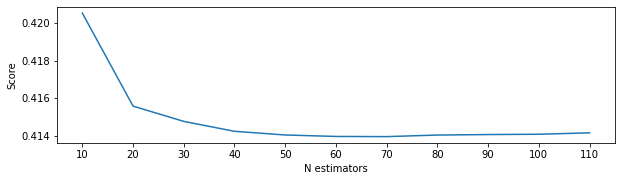

In [99]:
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.lineplot(x=n_estimators_range, y=scores)
plt.xticks(n_estimators_range)
plt.xlabel('N estimators')
plt.ylabel('Score')
plt.show()

In [100]:
n_estimators = 50

## Best model

In [101]:
best_model = XGBClassifier(tree_method='gpu_hist',
                          subsample=subsample,
                          min_child_weight=min_child_weight,
                          max_depth=max_depth,
                          n_estimators=n_estimators,
                          nthread=-1,
                          objective='binary:logistic')
best_model.fit(X_train, y_train)
predict = best_model.predict_proba(X_valid)
score = log_loss(y_valid, predict)
score

0.4140300681705499

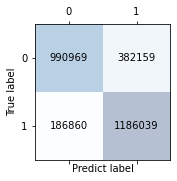

In [102]:
predictions = best_model.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=predictions, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

In [103]:
best_model.save_model('model.json')
best_model.save_model('model.txt')

## Select hyperparameter

In [28]:
def xgbc_cv(subsample, max_depth, min_child_weight, gamma, colsample_bytree, learning_rate, n_estimators, reg_alpha, reg_lambda):
    estimator = XGBClassifier(tree_method='gpu_hist',
                              subsample=subsample,
                              min_child_weight=int(min_child_weight),
                              max_depth=int(max_depth),
                              n_estimators=int(n_estimators),
                              gamma=gamma,
                              colsample_bytree=colsample_bytree,
                              learning_rate=learning_rate,
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              nthread=-1,
                              objective='binary:logistic')

    estimator.fit(X_train, y_train)
    models.append(estimator)
    predict = estimator.predict(X_valid)
    score = roc_auc_score(y_valid, predict)
    return score

In [30]:
models = []

hyperparameter_space = {
    'max_depth': (1,10),
    'min_child_weight': (10,20),
    'n_estimators' : (1,100),
    'subsample': (subsample, subsample),
    
    'gamma': (0.2,1),
    'colsample_bytree': (0,1),
    'learning_rate': (0,1),
    'reg_alpha': (0.2,1),
    'reg_lambda': (0.2,1)
}

xgbcBO = BayesianOptimization(f=xgbc_cv,
                              pbounds=hyperparameter_space,
                              random_state=2022,
                              verbose=10)
gp_params = {"alpha": 1e-10}
xgbcBO.maximize(init_points=5, n_iter=30, acq='ucb', kappa=3, **gp_params)

In [31]:
xgbcBO.max

{'target': 0.7936476737197266,
 'params': {'colsample_bytree': 0.7903772618805134,
  'gamma': 0.8897157899787469,
  'learning_rate': 0.6341207204615342,
  'max_depth': 9.762377999332175,
  'min_child_weight': 10.378170550827196,
  'n_estimators': 90.53764903082568,
  'reg_alpha': 0.6968254498097162,
  'reg_lambda': 0.8959355019906023,
  'subsample': 0.6}}

In [32]:
scores = []
for model in models:
    predict = model.predict_proba(X_test)
    score = log_loss(y_test, predict)
    scores.append(score)

In [33]:
best_model = models[np.argmin(scores)]
min(scores)

0.4127707564782246

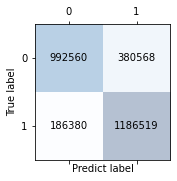

In [34]:
predict = best_model.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=predict, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

In [118]:
best_model.save_model('model.json')
best_model.save_model('model.txt')

# Submission

In [35]:
test_df = pd.read_csv('test.csv', dtype=np.dtype('uint8'))
test_df = test_df[important_columns]

In [36]:
best_model = XGBClassifier()
best_model.load_model('model.json')

In [37]:
sample_submission_df = pd.read_csv('sampleSubmission.gz', compression='gzip', nrows=100)
sample_submission_df.head(3)

id  click
0  10000174058809263569    0.5
1  10000182526920855428    0.5
2  10000554139829213984    0.5

In [38]:
submission_df = pd.read_csv('test.gz', compression='gzip', dtype={'id': np.dtype(str)})
submission_df = submission_df[['id']]

In [39]:
submission_df['click'] = best_model.predict_proba(test_df)[:,1]

In [40]:
submission_df

id     click
0        10000174058809263569  0.532910
1        10000182526920855428  0.941868
2        10000554139829213984  0.817501
3        10001094637809798845  0.665413
4        10001377041558670745  0.418593
...                       ...       ...
4577459   9998166651591969718  0.271347
4577460   9998249812366450951  0.512979
4577461     99988023653614546  0.019506
4577462   9999086574712596585  0.059766
4577463     99992636456518364  0.025187

[4577464 rows x 2 columns]

In [41]:
submission_df.to_csv('submission.csv', index=False)